# Mod 5 Project: 
## Classifying whether or not a Floodlight Open Participant has multiple sclerosis

Fisrt, let's import necessary packages and read in our cleaned dataframe.

In [149]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go

In [332]:
maindf = pd.read_csv('maindf.csv')

As you can see below, we have our diagnosis classification as well as a variety of tests from the Floodlight Open data, gender, country of residence, age and BMI.

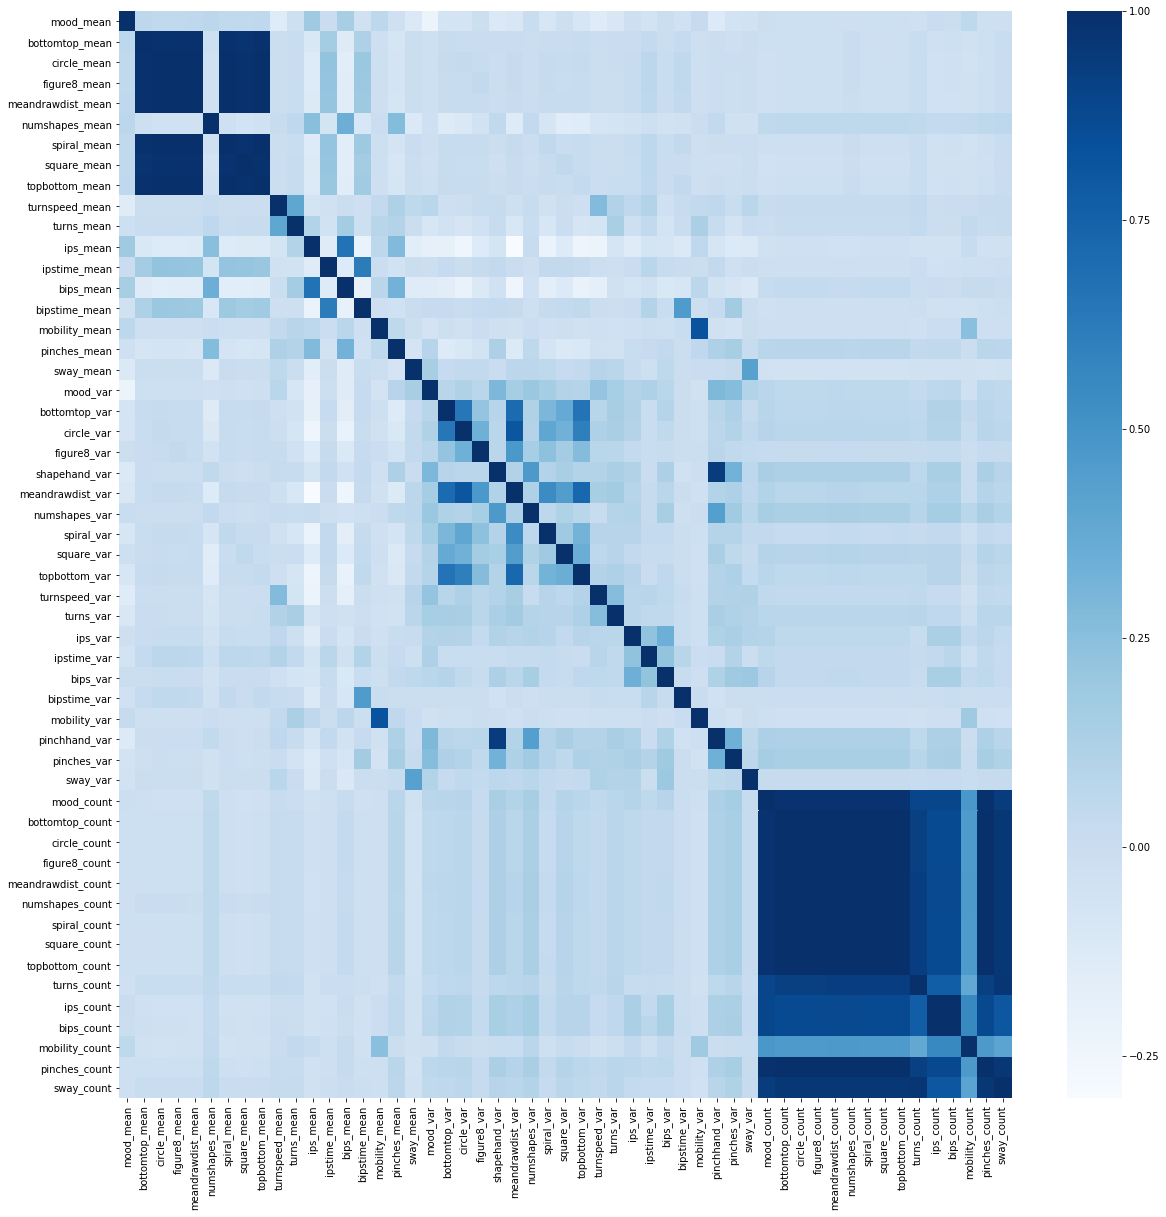

In [333]:
plt.figure(figsize = (20, 20))
sns.heatmap(maindf.iloc[:, 2:-13].corr(), cmap = 'Blues')

### Our baseline model is very close to 50% accuracy

In [335]:
hist = px.histogram(maindf, x='diagnosis', title = 'Number of Participants with or without MS', 
                  labels = {'diagnosis': 'Diagnosis'}, color = 'sex')
hist.show()


In [31]:
gen = px.histogram(maindf, x='sex', title = 'Number of Male and Female Participants',
                  labels = {'sex': 'Sex'}, color='sex')
gen.show()

In [256]:
# country = px.histogram(maindf, x='country', title = 'Number of Participants from Each Country', 
#                   labels = {'country': 'Country'})
# country.show()

In [253]:
formap = [['USA', '605', 37.09, -95.71], 
          ['Canada', 115, 56.13, -106.35], 
          ['Italy', 89, 41.87, 12.56], 
          ['Switzerland', 41, 46.82, 8.22], 
          ['Spain', 26, 40.46, -3.75], 
          ['Denmark', 12, 56.26, 9.50], 
          ['Czech Republic', 2, 49.82, 15.47], 
          ['Great Britain', 2, 55.37, -3.44], 
          ['Australia', 1, -25.27, 133.78]] 
df = pd.DataFrame(formap, columns = ['Country', 'Num', 'lat', 'long']) 
pop = [int(x) for x in list(df.Num)]
lat = [float(x) for x in list(df.lat)]
long = [float(x) for x in list(df.long)]

Special thanks to Alcid Analytics! https://alcidanalytics.com/p/geographic-heatmap-in-python

In [329]:
hmap = folium.Map(zoom_start=7)
max1 = float(max(pop))
hm_wide = HeatMap(list(zip(lat, long, pop)),
                   min_opacity=.4,
                   max_val=max1,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )
price_map = hmap.add_child(hm_wide)

In [330]:
hmap

In [252]:
# maindf.drop(['sex', 'country'], axis = 1, inplace = True)

## Baseline Model

Now let's split our data so we can fit a baseline model.

In [48]:
vals = maindf.iloc[:, 2:]
diag = maindf.iloc[:, 1:2]
X_train, X_test, y_train, y_test = train_test_split(vals, diag, test_size = 0.2, random_state = 42)

In [70]:
logregbase = LogisticRegression(random_state=42)
logregbase.fit(X_train, y_train)
# print(logregbase.score(X_train, y_train, sample_weight=None))

y_pred = logregbase.predict(X_test)
training_preds = logregbase.predict(X_train)


logregbase.coef_

logregbase.intercept_

training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, y_pred)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing accuracy: {:.4}%'.format(val_accuracy * 100))

Training Accuracy: 69.47%
Testing accuracy: 73.74%


In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          HC       0.81      0.62      0.70        90
          MS       0.69      0.85      0.76        89

   micro avg       0.74      0.74      0.74       179
   macro avg       0.75      0.74      0.73       179
weighted avg       0.75      0.74      0.73       179



Let's now take a look at our confusion matrix for our data to see how our predictions line up.

[Text(0, 0.5, 'HC'), Text(0, 1.5, 'MS')]

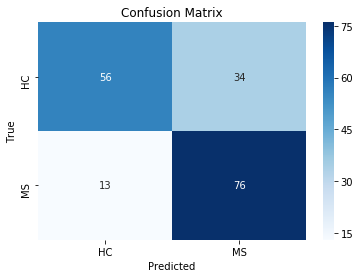

In [72]:
confusion = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
sns.heatmap(confusion, annot=True, ax = ax, cmap='Blues')

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['HC', 'MS']); ax.yaxis.set_ticklabels(['HC', 'MS'])

Text(0, 0.5, 'Feature')

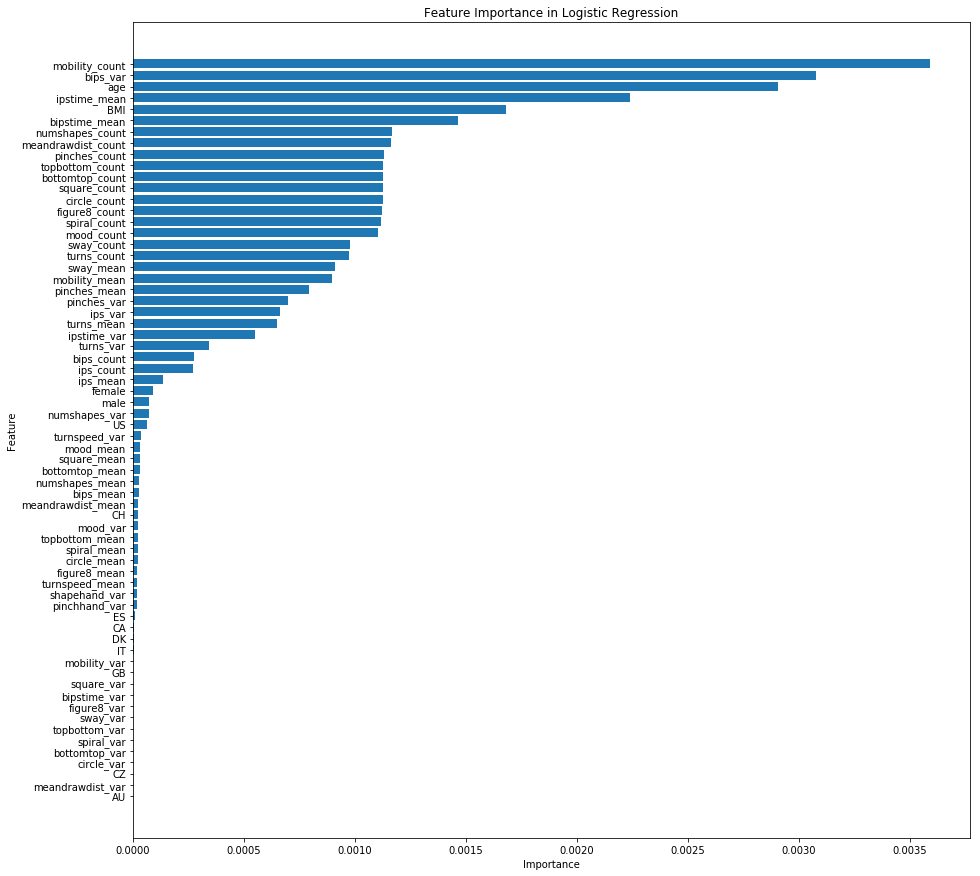

In [277]:
logcoefficients = pd.DataFrame(logregbase.coef_).T.set_index(vals.columns)
logcoefficients.columns = ['coefficient']
logcoefficients['coefficient'] = logcoefficients['coefficient'].apply(lambda x: abs(x))
logcoefficients = logcoefficients.sort_values(by = 'coefficient')

n_features = len(logcoefficients)
plt.figure(figsize=(15,15))
plt.barh(range(n_features), logcoefficients['coefficient'], align='center') 
plt.yticks(np.arange(n_features), logcoefficients.index)
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')

Our model can definitely be better, let's try something else. 

## Random Forest

In [90]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)
for_pred = forest.predict(X_test)
print('Training score: {:.4}%'.format(forest.score(X_train, y_train)*100))
print('Testing score: {:.4}%'.format(forest.score(X_test, y_test)*100))

Training score: 92.02%
Testing score: 84.92%


In [93]:
print(classification_report(y_test, for_pred))

              precision    recall  f1-score   support

          HC       0.85      0.86      0.85        90
          MS       0.85      0.84      0.85        89

   micro avg       0.85      0.85      0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



That's a lot better already - now let's take a look at our confusion matrix.

[Text(0, 0.5, 'HC'), Text(0, 1.5, 'MS')]

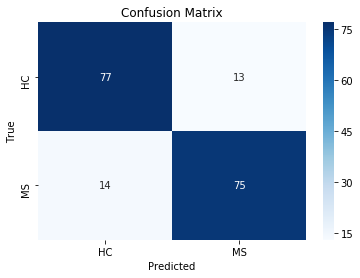

In [92]:
fconfusion = confusion_matrix(y_test, for_pred)

ax = plt.subplot()
sns.heatmap(fconfusion, annot=True, ax = ax, cmap='Blues')

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['HC', 'MS']); ax.yaxis.set_ticklabels(['HC', 'MS'])

Text(0, 0.5, 'Feature')

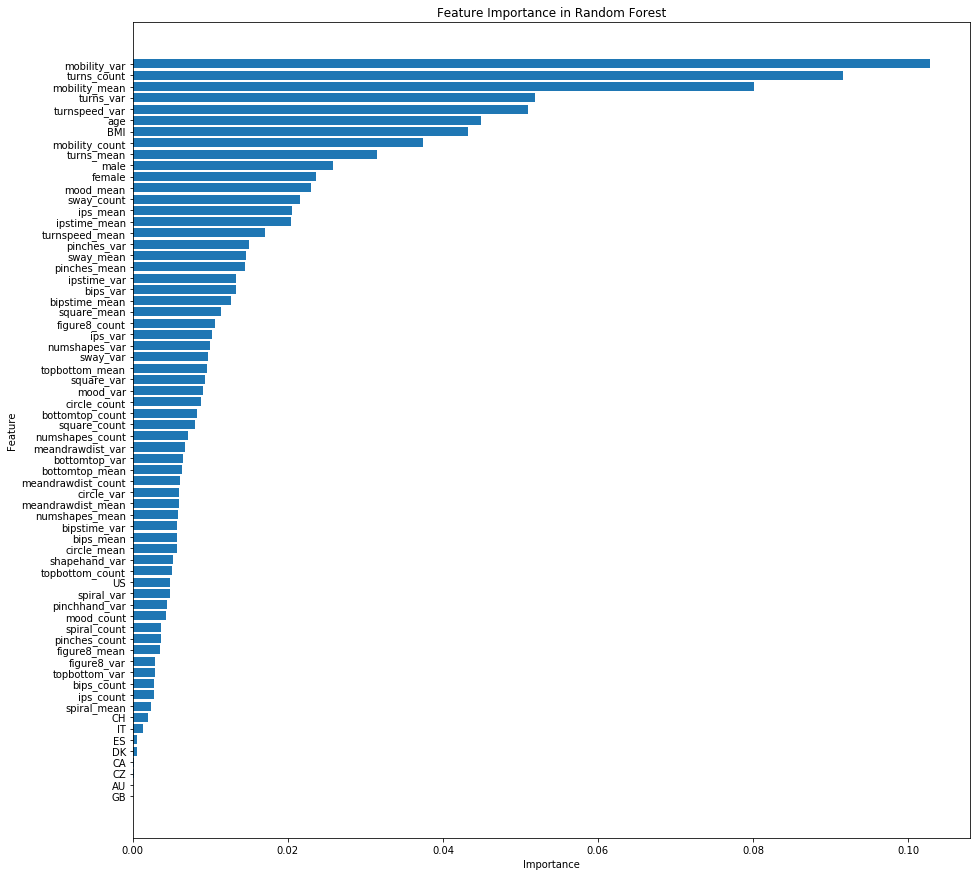

In [314]:
forfeatim = pd.DataFrame(forest.feature_importances_).set_index(X_train.columns)
forfeatim.columns = ['imp']
forfeatim = forfeatim.sort_values(by = 'imp')

n_features = len(forfeatim)
plt.figure(figsize=(15,15))
plt.barh(range(n_features), forfeatim['imp'], align='center') 
plt.yticks(np.arange(n_features), forfeatim.index)
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')

# ascending

### Grid Search to Tune our Random Forest Hyperparameters

In [102]:
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 11, 12, 13, 14, 15, 20, 25],
    'criterion' :['gini', 'entropy']
}

grid_forest = GridSearchCV(estimator=forest, param_grid=param_grid, cv= 5)
grid_forest.fit(X_train, y_train)

grid_forest.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'log2',
 'n_estimators': 400}

In [107]:
rfgrid=RandomForestClassifier(max_features='log2', n_estimators=400, max_depth=15, criterion='gini', random_state=42)
rfgrid.fit(X_train, y_train)
gridpred=rfgrid.predict(X_test)

print('Training score: {:.4}%'.format(rfgrid.score(X_train, y_train)*100))
print('Testing score: {:.4}%'.format(rfgrid.score(X_test, y_test)*100))

Training score: 100.0%
Testing score: 85.47%


In [108]:
print(classification_report(y_test, gridpred))

              precision    recall  f1-score   support

          HC       0.85      0.87      0.86        90
          MS       0.86      0.84      0.85        89

   micro avg       0.85      0.85      0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



[Text(0, 0.5, 'HC'), Text(0, 1.5, 'MS')]

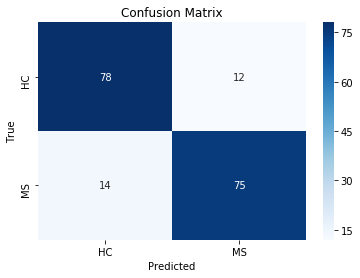

In [109]:
gridconfusion = confusion_matrix(y_test, gridpred)

ax = plt.subplot()
sns.heatmap(gridconfusion, annot=True, ax = ax, cmap='Blues')

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['HC', 'MS']); ax.yaxis.set_ticklabels(['HC', 'MS'])

Text(0, 0.5, 'Feature')

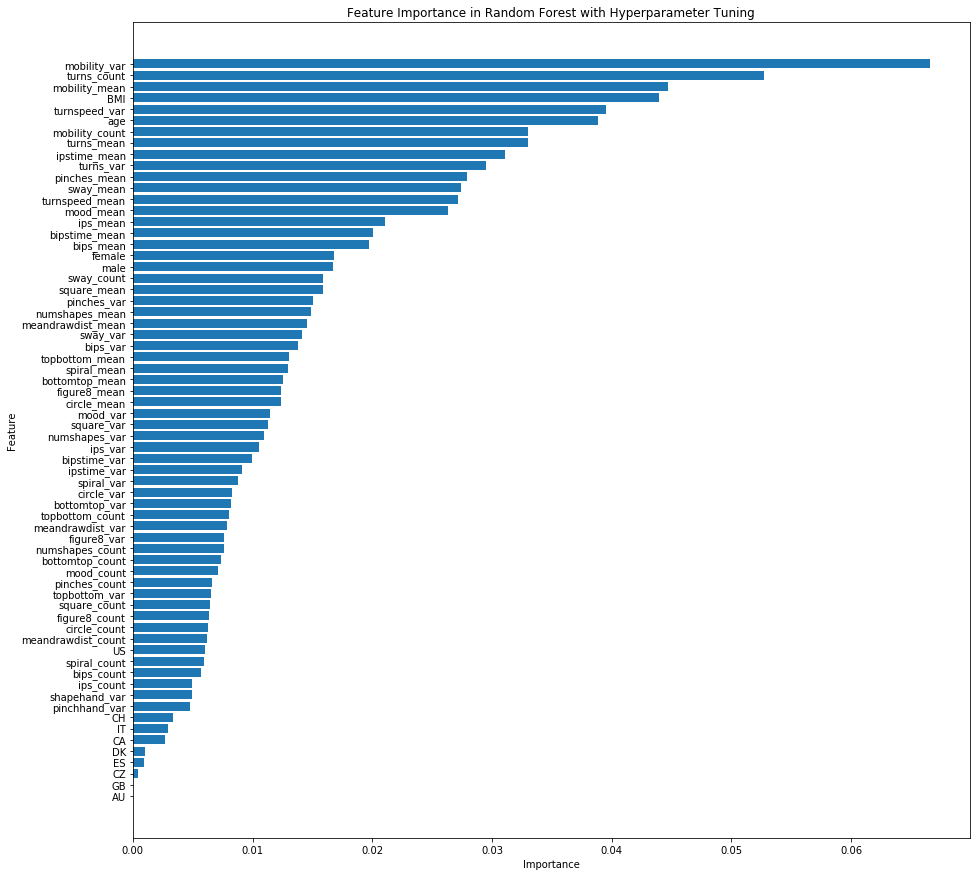

In [317]:
forfeatimg = pd.DataFrame(rfgrid.feature_importances_).set_index(X_train.columns)
forfeatimg.columns = ['imp']
forfeatimg = forfeatimg.sort_values(by = 'imp')

n_features = len(forfeatimg)
plt.figure(figsize=(15,15))
plt.barh(range(n_features), forfeatimg['imp'], align='center') 
plt.yticks(np.arange(n_features), forfeatimg.index)
plt.title('Feature Importance in Random Forest with Hyperparameter Tuning')
plt.xlabel('Importance')
plt.ylabel('Feature')

## Results of other models used on this data

In [116]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Accuracy']),
                 cells=dict(values=[['Logistic Regression with PCA', 'Random Forest with PCA', 'XGBoost with PCA', 
                                     'XGBoost'], 
                                    ['68.2%', '62%', '65.9%', '82.1%']]))
                     ])
fig.show()